In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Final2022/bionet')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchsummary import summary
import numpy as np
import math
import os
import psutil
print(torch.__version__)
print(torch.cuda.get_device_name(0))

1.12.0+cu113
Tesla V100-SXM2-16GB


In [3]:

transform = transforms.Compose([
#     transforms.CenterCrop(224),
  
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 
Batch_Size = 256
trainset = datasets.CIFAR10(root='../../data/', train=True,download=False, transform=transform)
testset = datasets.CIFAR10(root='../../data/',train=False,download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=4)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
class BasicBlock(nn.Module):
    """
    对于浅层网络，如ResNet-18/34等，用基本的Block
    基础模块没有压缩,所以expansion=1
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # 如果输入输出维度不等，则使用1x1卷积层来改变维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
    def forward(self, x):
        out = self.features(x)
#         print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out
basic_block = BasicBlock(64, 128)
print(basic_block)
x = torch.randn(2, 64, 32, 32)
y = basic_block(x)
print(y.shape)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 128, 32, 32])


In [5]:
class Bottleneck(nn.Module):
    """
    对于深层网络，我们使用BottleNeck，论文中提出其拥有近似的计算复杂度，但能节省很多资源
    zip_channels: 压缩后的维数，最后输出的维数是 expansion * zip_channels
    针对ResNet50/101/152的网络结构,主要是因为第三层是第二层的4倍的关系所以expansion=4
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
#         print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out
bottleneck = Bottleneck(256, 128)
print(bottleneck)
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)
print(y.shape)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 512, 32, 32])


In [6]:
class GaborConv2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        self.is_calculated = False

        self.conv_layer = nn.modules.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
        self.kernel_size = self.conv_layer.kernel_size

        # small addition to avoid division by zero
        self.delta = 1e-3

        # freq, theta, sigma are set up according to S. Meshgini,
        # A. Aghagolzadeh and H. Seyedarabi, "Face recognition using
        # Gabor filter bank, kernel principal component analysis
        # and support vector machine"
        self.freq = nn.Parameter((math.pi / 2) * math.sqrt(2) ** (-torch.randint(0, 5, (out_channels, in_channels))).type(torch.Tensor),requires_grad=True, )
        self.theta = nn.Parameter((math.pi / 8) * torch.randint(0, 8, (out_channels, in_channels)).type(torch.Tensor),requires_grad=True,)
        self.sigma = nn.Parameter(math.pi / self.freq, requires_grad=True)
        self.psi = nn.Parameter(math.pi * torch.rand(out_channels, in_channels), requires_grad=True)
        self.x0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[0] / 2]))[0], requires_grad=False)
        self.y0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[1] / 2]))[0], requires_grad=False)
        self.y, self.x = torch.meshgrid(
            [torch.linspace(-self.x0 + 1, self.x0 + 0, self.kernel_size[0]),
             torch.linspace(-self.y0 + 1, self.y0 + 0, self.kernel_size[1]),])
        self.y = nn.Parameter(self.y)
        self.x = nn.Parameter(self.x)
        self.weight = nn.Parameter(torch.empty(self.conv_layer.weight.shape, requires_grad=True),requires_grad=True,)


        self.register_parameter("freq", self.freq)
        self.register_parameter("theta", self.theta)
        self.register_parameter("sigma", self.sigma)
        self.register_parameter("psi", self.psi)
        self.register_parameter("x_shape", self.x0)
        self.register_parameter("y_shape", self.y0)
        self.register_parameter("y_grid", self.y)
        self.register_parameter("x_grid", self.x)
        self.register_parameter("weight", self.weight)

    def forward(self, input_tensor):
        if self.training:
            self.calculate_weights()
            #print(self.conv_layer.weight.data.shape)
            self.is_calculated = False
        if not self.training:
            if not self.is_calculated:
                self.calculate_weights()
                self.is_calculated = True
        return self.conv_layer(input_tensor)

    def calculate_weights(self):
        for i in range(self.conv_layer.out_channels):
            for j in range(self.conv_layer.in_channels):
                sigma = self.sigma[i, j].expand_as(self.y)
                freq = self.freq[i, j].expand_as(self.y)
                theta = self.theta[i, j].expand_as(self.y)
                psi = self.psi[i, j].expand_as(self.y)

                rotx = self.x * torch.cos(theta) + self.y * torch.sin(theta)
                roty = -self.x * torch.sin(theta) + self.y * torch.cos(theta)

                g = torch.exp(-0.5 * ((rotx ** 2 + roty ** 2) / (sigma + self.delta) ** 2))
                g = g * torch.cos(freq * rotx + psi)
                g = g / (2 * math.pi * sigma ** 2)
                self.conv_layer.weight.data[i, j] = g
class ResNet(nn.Module):
    """
    不同的ResNet架构都是统一的一层特征提取、四层残差，不同点在于每层残差的深度。
    对于cifar10，feature map size的变化如下：
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2] 
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool] 
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=10, verbose = False):
        super(ResNet, self).__init__()
        self.verbose = verbose

        self.in_channels = 64
        self.features = nn.Sequential(
            #nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            GaborConv2d(in_channels=5, out_channels= self.in_channels, kernel_size=(31, 31),padding=15),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        #使用_make_layer函数生成上表对应的conv2_x, conv3_x, conv4_x, conv5_x的结构
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 第一个block要进行降采样
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # 如果是Bottleneck Block的话需要对每层输入的维度进行压缩，压缩后再增加维数
            # 所以每层的输入维数也要跟着变
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    def opponency_encoder(self,data_tensor):
      num, channel, row, col=data_tensor.shape
      inputshape=(num,int(channel/3),row,col)
      r = data_tensor[:, 0, :, :]
      g = data_tensor[:, 1, :, :]
      b = data_tensor[:, 2, :, :]
      I = ((r + g + b) / 3).reshape(inputshape)
      R = torch.clamp(r - (g + b) / 2,min=0.0)
      G = torch.clamp(g - (r - b) / 2,min=0.0)
      B = torch.clamp(b - (r + g) / 2,min=0.0)
      Y = torch.clamp((r + g) / 2 - (r - g) / 2 - b,min=0.0)
      RG = torch.clamp(R - G,min=0.0).reshape(inputshape)
      GR = torch.clamp(G - R,min=0.0).reshape(inputshape)
      BY = torch.clamp(B - Y,min=0.0).reshape(inputshape)
      YB = torch.clamp(Y - B,min=0.0).reshape(inputshape)
      return torch.cat((I,RG,GR,BY,YB),1)

    def forward(self, x):
        out = self.features(self.opponency_encoder(x))
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        out = self.layer1(out)        
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))
        out = self.layer2(out)
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))
        out = self.layer3(out)
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
        out = self.layer4(out)
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [7]:
def ResNet18(verbose=False):
    return ResNet(BasicBlock, [2,2,2,2],verbose=verbose)

def ResNet34(verbose=False):
    return ResNet(BasicBlock, [3,4,6,3],verbose=verbose)

def ResNet50(verbose=False):
    return ResNet(Bottleneck, [3,4,6,3],verbose=verbose)

def ResNet101(verbose=False):
    return ResNet(Bottleneck, [3,4,23,3],verbose=verbose)

def ResNet152(verbose=False):
    return ResNet(Bottleneck, [3,8,36,3],verbose=verbose)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
net = ResNet34().to(device)
'''if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True'''
#summary(net,input_size=(3,32,32))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


"if device == 'cuda':\n    net = nn.DataParallel(net)\n    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能\n    torch.backends.cudnn.benchmark = True"

In [8]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std


def get_acc(outputs, label):
    total = outputs.shape[0]
    probs, pred_y = outputs.data.max(dim=1) # 得到概率
    correct = (pred_y == label).sum().data
    return correct / total


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

def train(net, trainloader, testloader, epoches, optimizer , criterion, scheduler , path = './model.pth', writer = None ,verbose = False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list  = []
    for i in range(epoches):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            # 释放内存
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            outputs = net(im)
            loss = criterion(outputs,label)
            # backward
            loss.backward()
            # 更新参数
            optimizer.step()

            train_loss += loss.data
            # probs, pred_y = outputs.data.max(dim=1) # 得到概率
            # # 正确的个数
            # train_acc += (pred_y==label).sum().item()
            # # 总数
            # total += label.size(0)
            train_acc += get_acc(outputs,label)
            # 打印下载进度
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        if verbose:
            train_acc_list.append(train_acc.item())
            train_loss_list.append(train_loss.item())
    #     print('train_loss:{:.6f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
        # 记录学习率
        lr = optimizer.param_groups[0]['lr']
        if verbose:
            lr_list.append(lr)
        # 更新学习率
        scheduler.step(train_loss)
        if testloader is not None:
            net.eval()
            with torch.no_grad():
                for step,data in enumerate(testloader,start=0):
                    im,label = data
                    im = im.to(device)
                    label = label.to(device)
                    # 释放内存
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                    outputs = net(im)
                    loss = criterion(outputs,label)
                    test_loss += loss.data
                    # probs, pred_y = outputs.data.max(dim=1) # 得到概率
                    # test_acc += (pred_y==label).sum().item()
                    # total += label.size(0)
                    test_acc += get_acc(outputs,label)
                    rate = (step + 1) / len(testloader)
                    a = "*" * int(rate * 50)
                    b = "." * (50 - int(rate * 50))
                    print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
            test_loss = test_loss / len(testloader)
            test_acc = test_acc * 100 / len(testloader)
            if verbose:
                test_loss_list.append(test_loss.item())
                test_acc_list.append(test_acc.item())
            end = time.time()
            print(
                '\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoches, train_loss, train_acc, test_loss, test_acc,lr), end='')
        else:
            end = time.time()
            print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(i+1,epoches,train_loss,train_acc,lr),end = '')
        time_ = int(end - start)
        h = time_ / 3600
        m = time_ % 3600 /60
        s = time_ % 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        # ====================== 使用 tensorboard ==================
        if writer is not None:
            writer.add_scalars('Loss', {'train': train_loss,
                                    'valid': test_loss}, i+1)
            writer.add_scalars('Acc', {'train': train_acc ,
                                   'valid': test_acc}, i+1)
            writer.add_scalars('Learning Rate',lr,i+1)
        # =========================================================
        # 打印所用时间
        print(time_str)
        # 如果取得更好的准确率，就保存模型
        if test_acc > best_acc:
            torch.save(net,path)
            best_acc = test_acc
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list
    return Acc, Loss, Lr
def plot_history(epoches, Acc, Loss, lr):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

In [9]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)

import time
epoch = 300

import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件夹已存在')
save_path = './model/OpponencyCifarGaborResNet34.pth'
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

文件夹已存在


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [  1/300]  Train Loss:2.344116  Train Acc:21.36% Test Loss:1.886814  Test Acc:30.20%  Learning Rate:0.100000	Time 01:13
Epoch [  2/300]  Train Loss:1.678778  Train Acc:37.49% Test Loss:1.611767  Test Acc:41.02%  Learning Rate:0.100000	Time 01:08
Epoch [  3/300]  Train Loss:1.478120  Train Acc:45.55% Test Loss:1.437468  Test Acc:47.43%  Learning Rate:0.100000	Time 01:06
Epoch [  4/300]  Train Loss:1.322062  Train Acc:51.88% Test Loss:1.262574  Test Acc:53.86%  Learning Rate:0.100000	Time 01:07
Epoch [  5/300]  Train Loss:1.182622  Train Acc:57.49% Test Loss:1.261565  Test Acc:55.21%  Learning Rate:0.100000	Time 01:06
Epoch [  6/300]  Train Loss:1.062231  Train Acc:62.04% Test Loss:1.119155  Test Acc:60.71%  Learning Rate:0.100000	Time 01:07
Epoch [  7/300]  Train Loss:0.964944  Train Acc:65.75% Test Loss:1.088789  Test Acc:62.49%  Learning Rate:0.100000	Time 01:06
Epoch [  8/300]  Train Loss:0.880889  Train Acc:69.06% Test Loss:0.938185  Test Acc:67.69%  Learning Rate:0.100000	Tim

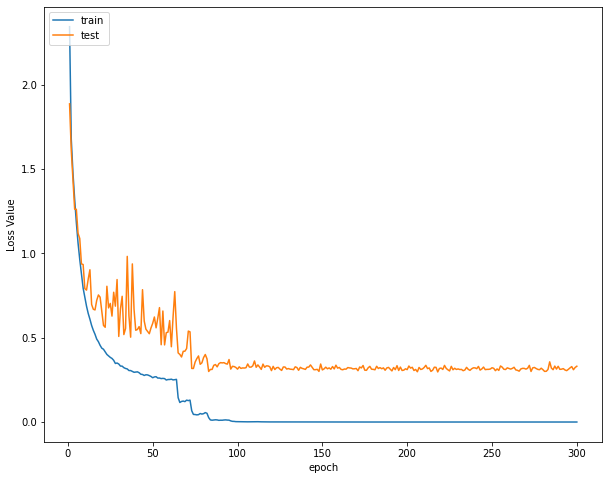

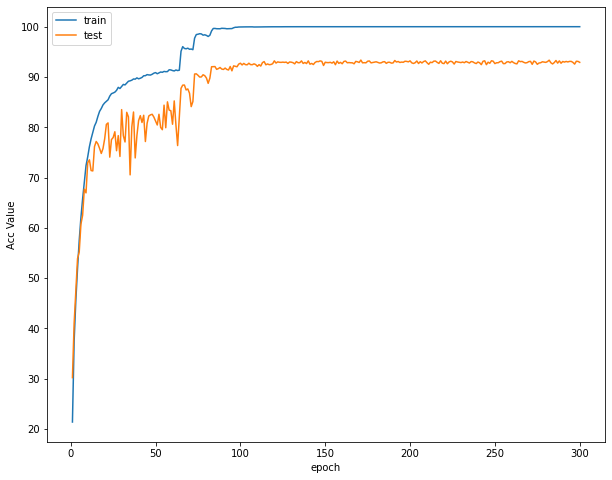

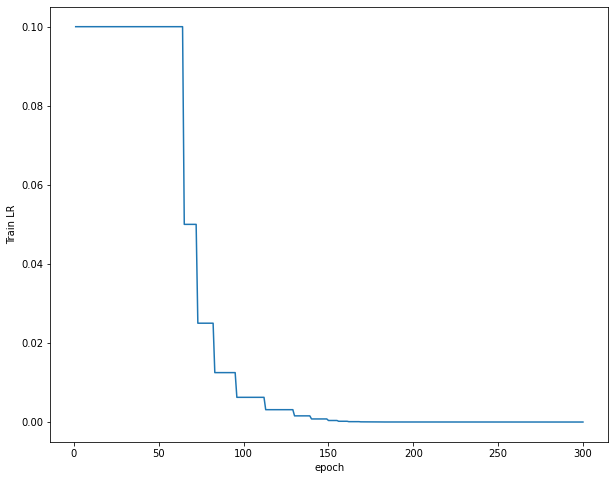

In [10]:
plot_history(epoch ,Acc, Loss, Lr)